In [73]:
import os, csv
import pandas as pd
from pyspark.sql import SparkSession, functions, types
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LinearSVC

spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel('WARN')

file_name = 'peak_1s.csv'

pd_df = pd.read_csv(file_name)
df = spark.createDataFrame(pd_df)

features = [col for col in df.columns if col not in ['trial', 'label', 'filename']]
train, validation = df.randomSplit([0.8, 0.2])

assembler = VectorAssembler(
    inputCols=features,
    outputCol='features')
lsvc = LinearSVC(maxIter=100, regParam=0.1)
pipeline = Pipeline(stages=[assembler, lsvc])
model = pipeline.fit(train)
predictions = model.transform(validation)

#metrics = MulticlassMetrics(predictionAndLabels)

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
print("Test Area Under PR: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})))

evaluator = MulticlassClassificationEvaluator()
print("f1: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))
print("Precision: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})))
print("Recall: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})))
print("Accuracy: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))


Test Area Under ROC: 0.9983354566956572
Test Area Under PR: 0.9832684628963922
f1: 0.9910009256215161
Precision: 0.9911806003743534
Recall: 0.9912369135323769
Accuracy: 0.9912369135323769


Confusion matrix, without normalization
[[12065    12]
 [  101   717]]
Normalized confusion matrix
[[9.99e-01 9.94e-04]
 [1.23e-01 8.77e-01]]


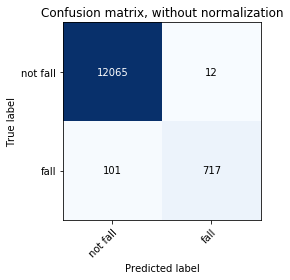

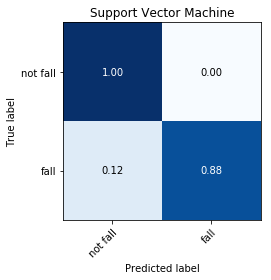

In [75]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = [0, 1]

y_pred = predictions.select(predictions['prediction']).toPandas().values.astype(np.int8)
y_test = predictions.select(predictions['label']).toPandas().values.astype(np.int8)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['not fall','fall']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Support Vector Machine')

plt.savefig('svm.png')
plt.show()


/home/salil/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "top left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


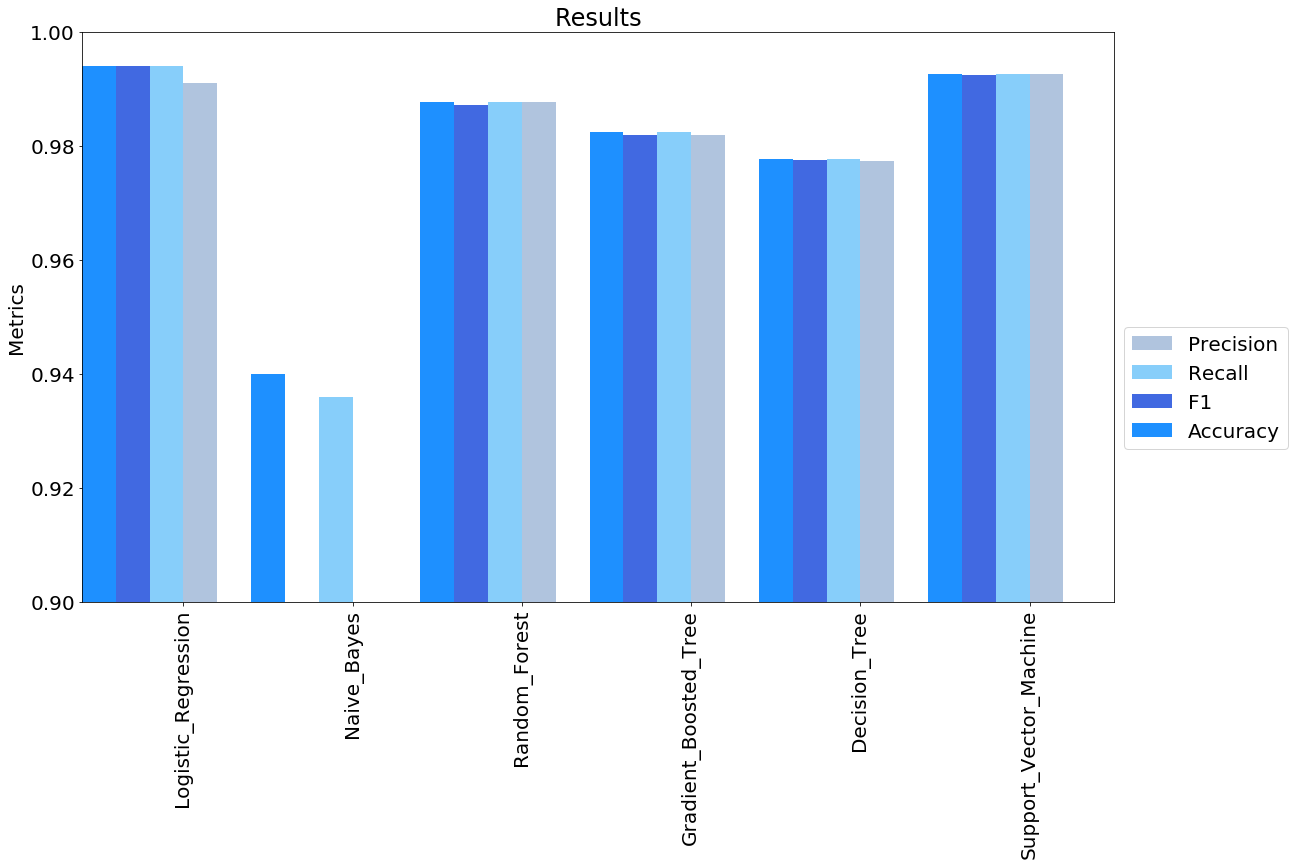

In [71]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO

#from matplotlib.pyplot import figure
#figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

matplotlib.rcParams.update({'font.size': 20})

#s = StringIO(""" Precision Recall F1 Accuracy
#Logistic_Regression 0.991 0.994 0.994 0.994
#Naive_Bayes 0.509 0.936 0.66 0.94
#Random_Forest 0.987677727013517 0.987659707073854 0.987094134896368 0.987659707073854
#Gradient_Boosted_Tree 0.981911922515953 0.982486755998753 0.981974276131145 0.982486755998753
#Decision_Tree 0.977345326954956 0.977625428482393 0.977473586522203 0.977625428482393
#Support_Vector_Machine 0.992617608806327 0.992643678160919 0.992457616117757 0.992643678160919
#""")

s = StringIO(""" Precision Recall F1 Accuracy
Logistic_Regression 0.991 0.994 0.994 0.994
Naive_Bayes 0.509 0.936 0.66 0.94
Random_Forest 0.987677727013517 0.987659707073854 0.987094134896368 0.987659707073854
Gradient_Boosted_Tree 0.981911922515953 0.982486755998753 0.981974276131145 0.982486755998753
Decision_Tree 0.977345326954956 0.977625428482393 0.977473586522203 0.977625428482393
Support_Vector_Machine 0.992617608806327 0.992643678160919 0.992457616117757 0.992643678160919
""")



df = pd.read_csv(s, index_col=0, delimiter=' ', skipinitialspace=True)

#fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
#ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.2

df.Precision.plot(kind='bar', color='lightsteelblue', ax=ax, width=width, position=0,
                  label='Precision')
df.Recall.plot(kind='bar', color='lightskyblue', ax=ax, width=width, position=1,
              label = 'Recall')
df.F1.plot(kind='bar', color='royalblue', ax=ax, width=width, position=2
          , label = 'F1')
df.Accuracy.plot(kind='bar', color='dodgerblue', ax=ax, width=width, position=3
                , label = 'Accuracy')

plt.legend()

#ax.set_ylim(ymin=0.9)
ax.set_ylim([0.90,1])
ax.set_xlim([-0.6, 5.5])
ax.set_ylabel('Metrics')
ax.legend(['Precision', 'Recall', 'F1', 'Accuracy'], loc='top left', bbox_to_anchor=(1.0, 0.5));
#ax2.set_ylabel('Price')
ax.set_title('Results')
plt.show()


In [11]:
import seaborn as sns

#df = pd.DataFrame(zip(x*3, ["y"]*3+["z"]*3+["k"]*3, y+z+k), columns=["time", "kind", "data"])
plt.figure(figsize=(10, 6))
sns.barplot(x="Precision", hue="kind", y="data", data=df)
plt.show()

ValueError: Could not interpret input 'data'

<Figure size 720x432 with 0 Axes>